# Neural Network

In [2]:
# Loading modules required for data manipulation an EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading modules required for modelling
from sklearn.neural_network import MLPRegressor         # To access the neural network regresssor
from sklearn.model_selection import KFold               # To create training/testing sets
from sklearn.model_selection import GridSearchCV        # To creat a tuning grid for hyperparameters
import itertools
from sklearn.decomposition import PCA                   # Feature selection tool
from sklearn.pipeline import make_pipeline              # Lets us build a pipeline

# Loading modules to assess error
from sklearn.metrics import mean_squared_error          # To measure the mean of residual errors 
from sklearn.metrics import r2_score                    # To measure the accuracy of the fit

# loading modules to assess model
from sklearn.model_selection import cross_val_score     # To determine the model's cross validation accuracy scores
from sklearn.metrics import accuracy_score              # To determine the model's accuracy
from sklearn.dummy import DummyRegressor                # To create a regressor baseline

# Loading modules to plot confusion matrix
import matplotlib.pyplot as plt                         # This one
import seaborn as sns                                   # ... and this one are used to create figure objects
from sklearn.metrics import confusion_matrix            # To create confusion matrix
%matplotlib inline

In [3]:
# Importing Data - already scaled
features = pd.read_csv('X.csv')
target = pd.read_csv('y.csv')

## Data Segregation
Splitting the data into 5 folds (80/20 split) and eabling reproducibility

In [4]:
# Creating numpy arrays of data to get k-folds 
X = np.array(features)
y = np.array(target)
kf = KFold(n_splits = 5, 
           random_state = 42, 
           shuffle =True)

print('Number of splits: ', kf.get_n_splits(X))

# Assigning the training and testing sets data based on the splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Returning array back to Dataframe
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

# Assessing sets
print('Dataset shapes: ', features.shape, "and ", target.shape)
print('Training set shape: ', X_train.shape, "and", y_train.shape)
print('Testing set shape: ', X_test.shape, "and ", y_test.shape)

Number of splits:  5
Dataset shapes:  (822, 30) and  (822, 1)
Training set shape:  (658, 30) and (658, 1)
Testing set shape:  (164, 30) and  (164, 1)


#### Creating baseline

In [5]:
# Creating naive baseline to compare with
baseline = np.mean(y_train.iloc[:, 0].to_numpy())
y_baseline = np.repeat(baseline, len(y_test.iloc[:, 0].to_numpy()))
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(naive_MSE)
naive_rr = r2_score(y_test, y_baseline)

# Creating a DummyRegressor baseline
dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = dummy_mean.predict(X_test)
dummy_MSE = mean_squared_error(y_test, y_predict_dummy_mean)
dummy_RMSE = np.sqrt(dummy_MSE)
dummy_rr = r2_score(y_test, y_predict_dummy_mean)

## Training Model

In [15]:
# Building the neural network model
    # input layer has 31 nodes, output node has one, hidden layers should have between 1 and 31 nodes
model_nn = MLPRegressor(max_iter = 800,
                        solver = 'adam',            
                        learning_rate = 'constant',  # Others would set aside data which I don't think we have enough to do
                        random_state = 42)

print("Before optimization with tuning: ", model_nn.get_params())

Before optimization with tuning:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 800, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [26]:
# Trainning the model on training data
model_nn.fit(X_train, y_train.iloc[:, 0].to_numpy())

MLPRegressor(max_iter=800, random_state=42)

In [17]:
# Testing the model on training and on testing sets
preds_train_untuned_nn = model_nn.predict(X_train)
preds_test_untuned_nn = model_nn.predict(X_test)

# Determining Cross validation scores
def average(lst):
    return sum(lst) / len(lst)
score_untuned_nn = cross_val_score(model_nn, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (untuned): ", score_untuned_nn, "\nCV score = ", average(score_untuned_nn)) 

# Measuring MSE
MSE_training_preds = mean_squared_error(y_train, preds_train_untuned_nn)
MSE_testing_preds = mean_squared_error(y_test, preds_test_untuned_nn)

# Measuring RMSE
RMSE_training_preds = np.sqrt(MSE_training_preds)
RMSE_testing_preds = np.sqrt(MSE_testing_preds)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, preds_train_untuned_nn)
rsq_testing_preds = r2_score(y_test, preds_test_untuned_nn)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'NN on Training', 'NN on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the untuned model:")
scores_df.head()

Cross Validation scores (untuned):  [-0.37392357 -1.04967213 -0.84126242 -0.54517737  0.07939713] 
CV score =  -0.5461276719805462

Here are some performace metrics associated with the mean baseline and the untuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,NN on Training,0.00967,0.09832,0.59431
3,NN on Testing,0.02123,0.14570,0.10495


## Tuning Model

In [18]:
# Hyperparameters to calibrate 
param_grid = {'hidden_layer_sizes': [50,100,150] 
              #+ list(itertools.permutations([50,100,150],2)) 
              #list(itertools.permutations([50,100,150],3))
              ,
              'activation': ['relu', 'identity', 'tanh','logistic'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive'] # invascaling seems to increase time
             }

# Hyperparameters to calibrate 
tuned_nn = GridSearchCV(model_nn, param_grid, cv = 5)

In [27]:
# Training the tuned model on training data
tuned_nn = tuned_nn.fit(X_train, y_train.iloc[:, 0].to_numpy())
print("Best set of hyperparameters: ", tuned_nn.best_params_)   
#{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': 150, 'learning_rate': 'constant'}

# Testing the model on training set and on testing set
preds_train_tuned_nn = tuned_nn.predict(X_train)
preds_test_tuned_nn = tuned_nn.predict(X_test)

# Determining Cross validation scores
score_tuned_nn = cross_val_score(tuned_nn, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (tuned): ", score_tuned_nn, "\nCV score = ", average(score_tuned_nn)) 

# Measuring MSE 
MSE_training_preds = mean_squared_error(y_train, preds_train_tuned_nn)
MSE_testing_preds = mean_squared_error(y_test, preds_test_tuned_nn)

# Measuring RMSE 
RMSE_training_preds = np.sqrt(MSE_training_preds)
RMSE_testing_preds = np.sqrt(MSE_testing_preds)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, preds_train_tuned_nn)
rsq_testing_preds = r2_score(y_test, preds_test_tuned_nn)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'NN on Training', 'NN on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5),  round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the tuned model:")
scores_df.head()

Best set of hyperparameters:  {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': 150, 'learning_rate': 'constant'}
Cross Validation scores (tuned):  [0.8192512  0.61560146 0.81754424 0.84009808 0.7681934 ] 
CV score =  0.7721376761711358

Here are some performace metrics associated with the mean baseline and the tuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,NN on Training,0.00339,0.05820,0.85785
3,NN on Testing,0.00386,0.06212,0.83731


In [28]:
# Creating model with feature selection (PCA)
pca = PCA(whiten = True,                                # Using uncorrelated components
          random_state = 42)                            # Setting a seed

model_pca_nn = make_pipeline(pca, tuned_nn)

# Tuning model
grid_nn = {'pca__n_components': [#1, 5, 10, 15,
            20, 25, 29, 30],}

tuned_nn_pca = GridSearchCV(model_pca_nn, grid_nn, cv = 5)

# Trainning model on training data
tuned_nn_pca.fit(X_train, y_train.iloc[:, 0].to_numpy())
print(tuned_nn_pca.best_params_)

# Testing model on training and testing set
pca_train_tuned_prediction = tuned_nn_pca.predict(X_train)
pca_test_tuned_prediction = tuned_nn_pca.predict(X_test)

# Measuring MSE 
MSE_training_preds_pca = mean_squared_error(y_train, pca_train_untuned_prediction)
MSE_testing_preds_pca = mean_squared_error(y_test, pca_test_untuned_prediction)

# Measuring RMSE 
RMSE_training_preds_pca = np.sqrt(MSE_training_preds_pca)
RMSE_testing_preds_pca = np.sqrt(MSE_testing_preds_pca)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, pca_train_tuned_prediction)
rsq_testing_preds = r2_score(y_test, pca_test_tuned_prediction)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'NN on Training', 'NN on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), 
                   round(MSE_training_preds_pca, 5), round(MSE_testing_preds_pca, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), 
                   round(RMSE_training_preds_pca, 5), round(RMSE_testing_preds_pca, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), 
                      round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the PCA/tuned model:")
scores_df.head()

{'pca__n_components': 29}

Here are some performace metrics associated with the mean baseline and the PCA/tuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,NN on Training,0.00331,0.05757,0.86154
3,NN on Testing,0.00364,0.06029,0.84443


Text(0, 0.5, 'Fitted values')

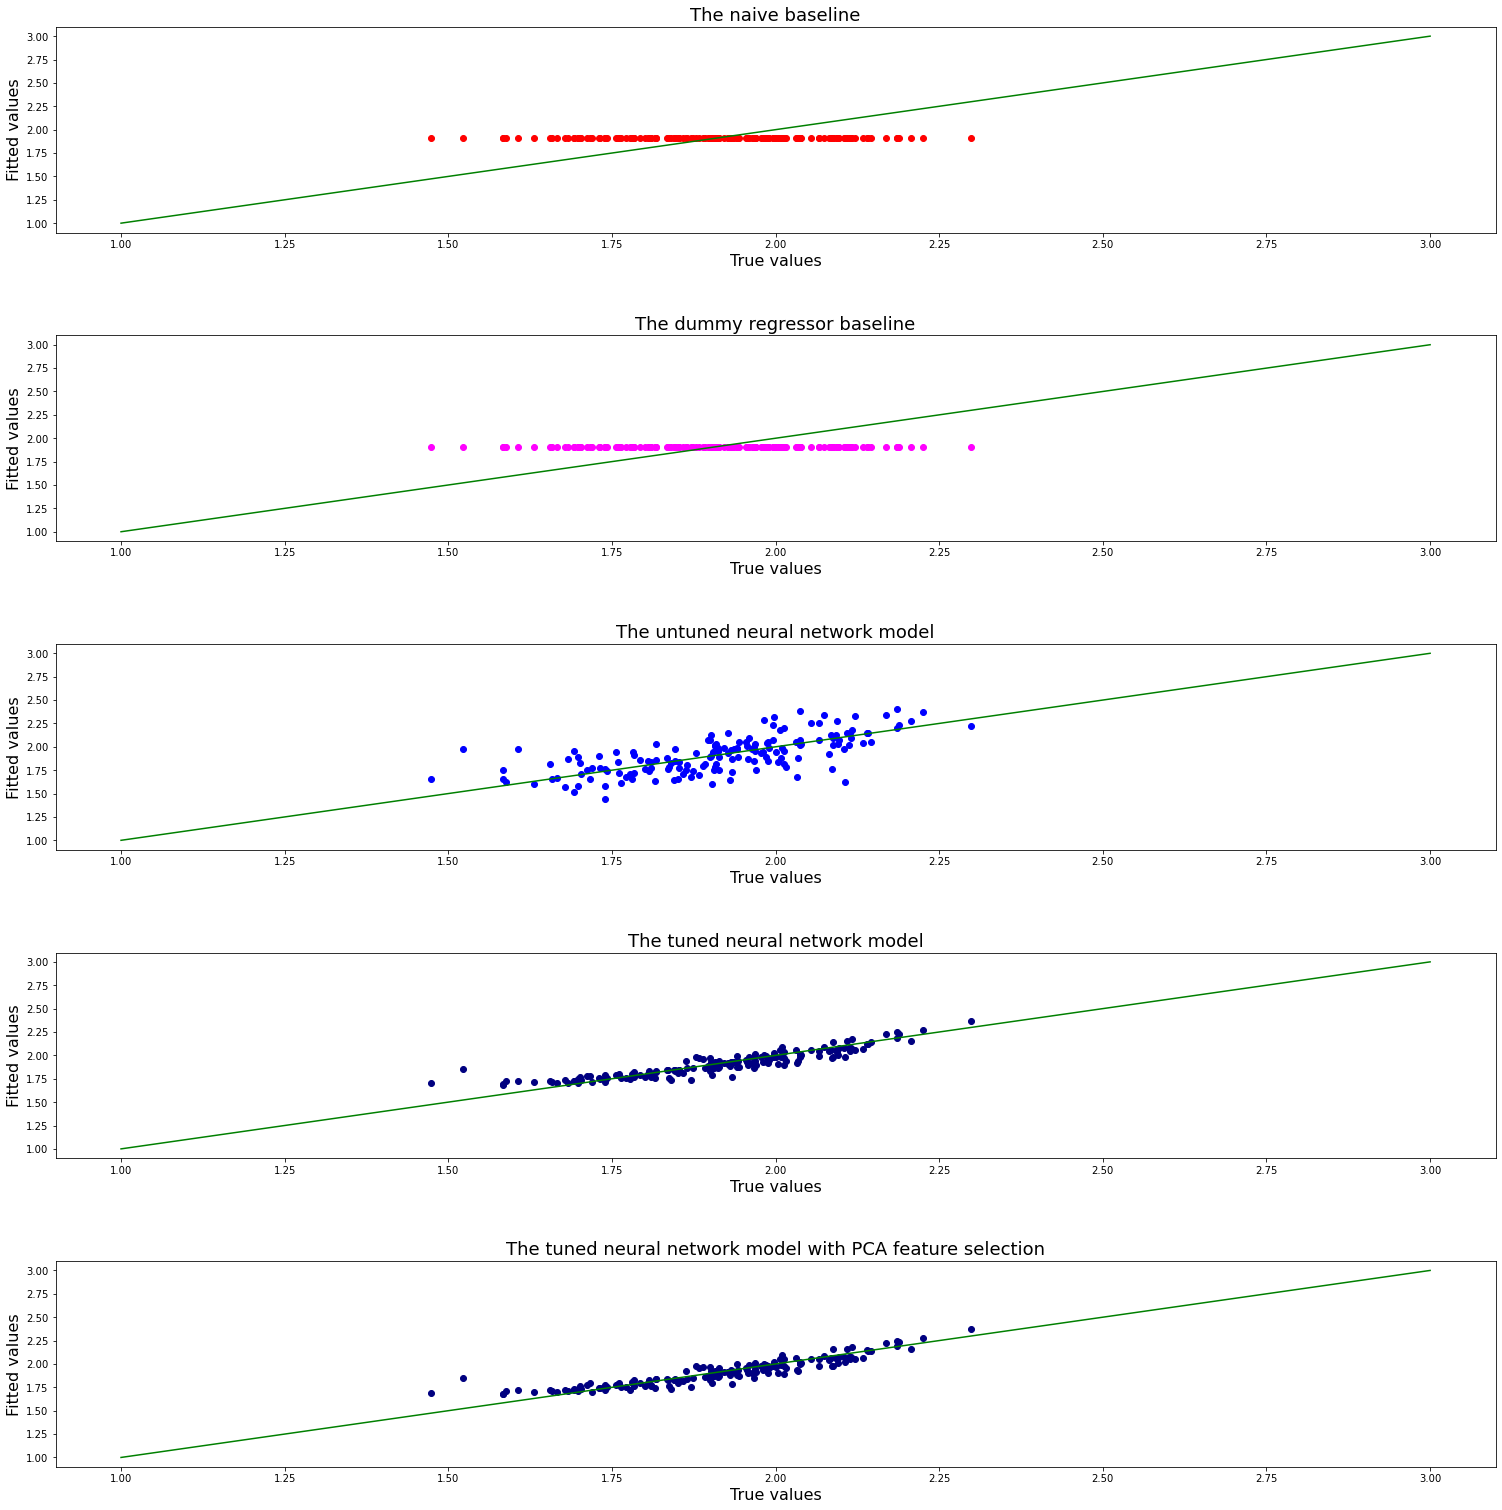

In [29]:
fig = plt.figure(figsize = (20,20))
fig.subplots_adjust( left = 0, right = 1, bottom = 0, top = 1, hspace =0.5, wspace = 0.5)

ax = fig.add_subplot(5,1, 1)
plt.scatter(y_test, y_baseline, color = 'red')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The naive baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5,1, 2)
plt.scatter(y_test, y_predict_dummy_mean, color = 'magenta')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The dummy regressor baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5,1, 3)
plt.scatter(y_test, preds_test_untuned_nn, color = 'blue')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The untuned neural network model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5,1, 4)
plt.scatter(y_test, preds_test_tuned_nn, color = 'navy')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The tuned neural network model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5,1, 5)
plt.scatter(y_test, pca_test_tuned_prediction, color = 'navy')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The tuned neural network model with PCA feature selection", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)